In [1]:
%matplotlib inline
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# clear_cache('cython')

# f-I curves for Type I and II neurons

In [6]:
#### Borrowing from input factory of neurodynex package

def get_step_current(t_start, t_end, t_total, unit_time, amplitudes):

    N = len(amplitudes)
    I_arr = np.zeros((t_total,N))*amp
    for i in range(N):
        I_arr[t_start : t_end+1, i] = amplitudes[i]
    
    I_arr = TimedArray(I_arr, dt = 1*unit_time)
    return I_arr

In [7]:
I_arr = get_step_current(100, 1100, 1100, ms, [0.1, 1, 10]*pA)
I_arr.values

array([[0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00],
       ...,
       [1.e-13, 1.e-12, 1.e-11],
       [1.e-13, 1.e-12, 1.e-11],
       [1.e-13, 1.e-12, 1.e-11]])

In [13]:
def typeI_neuron(I_arr, duration, N_neurons):
    g_1 = 4.4 * (1 / mV)
    g_2 = 8 * (1 / mV)
    g_L = 2
    V_1 = 120 * mV
    V_2 = -84 * mV
    V_L = -60 * mV
    phi = 0.06666667
    R = 100 * Gohm

    eqs = """
        I = I_arr(t, i) : amp
        winf = (0.5*mV)*( 1 + tanh((v-12*mV)/(17*mV)) ) : volt
        tau = (1*ms)/cosh((v-12*mV)/(2*17*mV)) : second
        m = (0.5*mV)*(1+tanh((v+1.2*mV)/(18*mV))) : volt
        dv/dt = (-g_1*m*(v-V_1) - g_2*w*(v-V_2) - g_L*(v-V_L) + I*R)/(20*ms) : volt
        dw/dt = phi*(winf-w)/tau : volt
    """

    neuron = NeuronGroup(N_neurons, eqs, method=euler)
    neuron.v = V_L

    statemon = StateMonitor(neuron, ["v", "w", "I"], record=True)

    tI_net = Network(neuron)
    tI_net.add(statemon)
    tI_net.run(duration)

    return statemon

def typeII_neuron(I_arr, duration, N_neurons):
    
    a = 1.25
    tau = 15.6 * ms

    eqs = """
        I = I_arr(t, i) : amp
        dv/dt = (v - (v**3)/(3*mvolt*mvolt) - w + I*Gohm)/ms : volt
        dw/dt = (a*(v+0.7*mvolt)-w)/tau : volt
        """

    neuron = NeuronGroup(N_neurons, eqs, method=euler)
    neuron.v = 0

    statemon = StateMonitor(neuron, ["v", "w", "I"], record=True)

    tII_net = Network(neuron)
    tII_net.add(statemon)
    tII_net.run(duration)

    return statemon


In [10]:
I_arr = get_step_current(100, 1100, 1100, ms, [i*0.01 for i in range(100)]*pA)
I_arr.values.shape

(1100, 100)

In [12]:
statemon_tI = typeI_neuron(I_arr, duration = 1100*ms, N_neurons = I_arr.values.shape[1])

In [14]:
statemon_tII = typeII_neuron(I_arr, duration = 1100*ms, N_neurons = I_arr.values.shape[1])

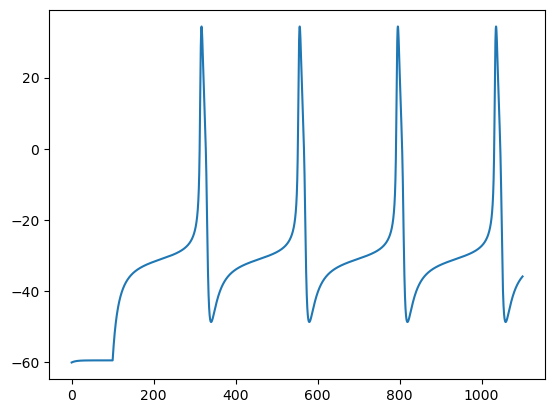

In [31]:
plt.plot(statemon_tI.t/ms, statemon_tI.v[38]/mV)

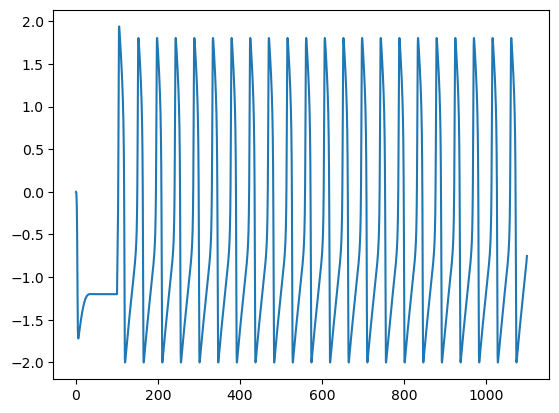

In [38]:
plt.plot(statemon_tII.t/ms, statemon_tII.v[35]/mV)

In [59]:
statemon_tI.v.shape[0]

100

In [57]:
statemon_tI.t.shape

(11000,)

In [74]:
def get_spike_time(statemon, threshold):
    spike_trains = []
    firing_rate = []
    for i in range(len(statemon.v)):
        v = statemon.v[i]/mV
        ith_train = [] 
        for j in range(len(v)):
            if (v[j] > threshold) & (v[j-1] < threshold):
                ith_train.append(statemon.t[j]/second)
        spike_trains.append(ith_train)
        if len(ith_train) > 1:
            isi = np.array(ith_train)[1:] - np.array(ith_train)[:-1]
            firing_rate.append(1/np.mean(isi) )
        else:
            firing_rate.append(0)
    return spike_trains, firing_rate

In [75]:
tI_spiketrain, tI_firing_rate = get_spike_time(statemon_tI, threshold = 0)
tII_spiketrain, tII_firing_rate = get_spike_time(statemon_tII, threshold = 0)

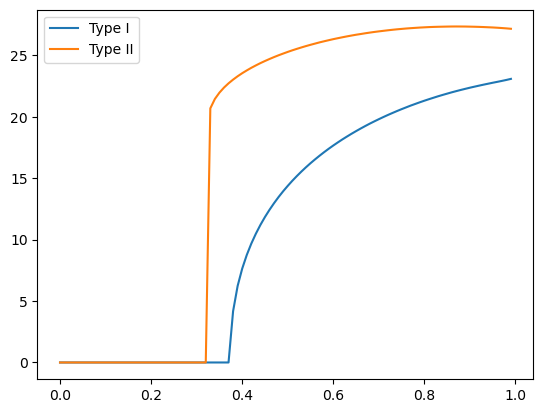

In [78]:
plt.plot([i*0.01 for i in range(100)], tI_firing_rate, label = "Type I")
plt.plot([i*0.01 for i in range(100)], tII_firing_rate, label = "Type II")
plt.legend()